# Week 41 - exercises
Nadia Ørning\
Github: https://github.com/neorning97/FYS-STK4155/tree/main/WeeklyExercises/Week41

In [8]:
from random import random, seed
import autograd.numpy as np
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import linear_model
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.random import normal, uniform
from sklearn.preprocessing import MinMaxScaler
import sys
from autograd import grad

def generate_data(noise=True, step_size=0.05 , FrankesFunction=True):
    # Arrange x and y
    x = np.arange(0, 1, step_size)
    y = np.arange(0, 1, step_size)

    # Create meshgrid of x and y
    X, Y = np.meshgrid(x, y)
    
    if FrankesFunction:
        # Calculate the values for Franke function
        z = FrankeFunction(X, Y, noise=noise).flatten()
    else:
        z = TestFunction(X, Y, noise=noise).flatten()

    # Flatten x and y for plotting
    x = X.flatten()
    y = Y.flatten()
    
    return x, y, z


def TestFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0

    return  x**2 + y**2 + 2*x*y + random_noise

    
def FrankeFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + random_noise


def create_X(x, y, n, intercept=True):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2)

    if intercept:
        X = np.ones((N,l))

        for i in range(1,n+1):
            q = int((i)*(i+1)/2)
            for k in range(i+1):
                X[:,q+k] = (x**(i-k))*(y**k)

    else:
        X = np.ones((N,l-1))

        for i in range(1,n+1):
            q = int((i)*(i+1)/2) - 1
            for k in range(i+1):
                X[:,q+k] = (x**(i-k))*(y**k)

    return X

def GradientDescent(X_train, X_test, z_train, n,  Niterations=1000, delta_momentum = 0.3, lmb = 0.001, momentum = True, Ridge = False):
    z_train = z_train.reshape(-1,1)
    if Ridge:
        H = (2.0/n) * X_train.T @ X_train + 2 * lmb * np.identity(X_train.shape[1])
        def gradient(X_train , beta , lmb):
            return (2.0/n) * X_train.T @ (X_train @ beta - z_train) + 2 * lmb * beta
    else:
        H = (2.0/n)* X_train.T @ X_train
        def gradient(X_train, beta, lmb):
            return (2.0/n)* X_train.T @ (X_train @ beta - z_train)

    change = 0.0

    #Get the eigenvalues

    EigValues, EigVectors = np.linalg.eig(H)

    if momentum:
        def algorithm(eta, gradients , beta , change):
            new_change = eta*gradients + delta_momentum * change
            beta-= new_change
            change = new_change
            return beta
    else: 
        def algorithm(eta, gradients ,beta , change):
            beta -= np.abs(eta)*gradients
            return beta

    # Initialize beta and the other parameters
    beta = np.random.randn(X_train.shape[1],1)
    eta = 1.0/np.max(EigValues)
    
    
    for iter in range(Niterations):

        gradients = gradient(X_train, beta, lmb)
        beta = algorithm(eta, gradients, beta, change)     
  
    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    z_tilde = z_tilde.reshape(-1,1)
    z_predict = z_predict.reshape(-1,1)

    return z_tilde , z_predict , beta

def StochasticGD(X_train, X_test, z_train, n, n_epochs=50, size_batch=5, Niterations=1000, delta_momentum = 0.3, lmb= 0.001, learningschedule = True, momentum = True, Ridge = False):
    z_train = z_train.reshape(-1,1)
    M = size_batch
    m = int(n/M)#number of minibatches
    t0, t1 = 5, 50
    
    if Ridge:
        H = (2.0/n)* X_train.T @ X_train + 2 * lmb * np.identity(X_train.shape[1])
        def gradient(X_train, z_train, beta, lmb):
            return (2.0/n) * X_train.T @ (X_train @ beta - z_train) + 2 * lmb * beta
    else:
        H = (2.0/n) * X_train.T @ X_train
        def gradient(X_train, z_train, beta, lmb):
            return (2.0/n) * X_train.T @ (X_train @ beta - z_train)
    
    EigValues, EigVectors = np.linalg.eig(H)
    change = 0

    if learningschedule:
        def learning_schedule(t):
            return t0/(t+t1)
    else:
        def learning_schedule(t):
            return 1.0/np.max(EigValues)
        
    if momentum:
        def algorithm(eta, gradients, beta, change):
            new_change = eta * gradients + delta_momentum * change
            beta -= new_change
            change = new_change
            return beta
    else: 
        def algorithm(eta, gradients, beta, change):
            beta -= eta * gradients
            return beta
            

    beta = np.random.randn(X_train.shape[1],1)
    z_train = z_train.reshape(-1,1)

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M + np.random.randint(m)
            xi = X_train[random_index:random_index+M]
            zi = z_train[random_index:random_index+M]
            gradients = gradient(xi, zi, beta, lmb)
            eta = learning_schedule(epoch*m+i)
            beta = algorithm(eta, gradients, beta, change)

    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    z_tilde = z_tilde.reshape(-1,1)
    z_predict = z_predict.reshape(-1,1)

    return z_tilde, z_predict, beta

def CostOLS(y, X, beta):
    return np.sum((y-X @ beta)**2)

def CostRidge(y, X, beta, lmb=0.001):
    return np.sum((y-X @ beta)**2) + lmb*np.sum(beta**2)


def AdaGradGD(X_train, X_test, z_train, n, n_epochs=50, size_batch=5, Niterations=1000, delta_momentum = 0.3, delta = 1e-8, lmb=0.001, learningschedule = True, momentum = True, stochastic = True, Ridge = False):
    z_train = z_train.reshape(-1,1)
    M =size_batch
    m = int(n/M )#number of minibatches
    t0, t1 = 5, 50
    Giter = 0.0
    
    H = (2.0/n) * X_train.T @ X_train
    EigValues, EigVectors = np.linalg.eig(H)
    change = 0

    if learningschedule:
        def learning_schedule(t):
            return t0/(t+t1)
    else:
        def learning_schedule(t):
            return np.real(1.0/np.max(EigValues))
        
    if momentum:
        def algorithm(eta, gradients, beta, change, Giter):
            Giter += gradients*gradients
            update = gradients*eta/(delta+np.sqrt(Giter))
            new_change = update + delta_momentum * change
            beta -= new_change
            change = new_change
            return beta
    else: 
        def algorithm(eta, gradients, beta, change, Giter):
            Giter += gradients*gradients
            update = gradients*eta/(delta+np.sqrt(Giter))
            beta -= update
            return beta
        
    if Ridge: 
        training_gradient = grad(CostRidge,2)
    else:
        training_gradient = grad(CostOLS,2)

    beta = np.random.randn(X_train.shape[1],1)
    z_train = z_train.reshape(-1,1)

    
    if stochastic:
        for epoch in range(n_epochs):
            Giter = 0.0
            for i in range(m):
                random_index = M + np.random.randint(m)
                xi = X_train[random_index:random_index+M]
                zi = z_train[random_index:random_index+M]
                eta = learning_schedule(epoch*m+i)
                gradients = (1.0/M)*training_gradient(zi, xi, beta)
                beta =algorithm(eta, gradients, beta, change, Giter)
    else:
        for iter in range(Niterations):

            eta = np.real(1.0/np.max(EigValues))
            gradients = (1.0/M)*training_gradient(z_train, X_train, beta)
            beta =algorithm(eta, gradients, beta, change, Giter)
            

    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    z_tilde = z_tilde.reshape(-1,1)
    z_predict = z_predict.reshape(-1,1)

    return z_tilde , z_predict , beta

def RMSpropGD(X_train, X_test, z_train, n, n_epochs=50, size_batch=5, Niterations=1000, delta_momentum = 0.3, delta = 1e-8, rho=0.99, lmb=0.001, learningschedule = True, momentum = True, stochastic = True, Ridge = False):
    z_train = z_train.reshape(-1,1) 
    M = size_batch
    m = int(n/M )#number of minibatches
    t0, t1 = 5, 50
    Giter = 0.0
    
    H = (2.0/n) * X_train.T @ X_train
    EigValues, EigVectors = np.linalg.eig(H)
    change = 0

    if learningschedule:
        def learning_schedule(t):
            return t0/(t+t1)
    else:
        def learning_schedule(t):
            return np.real(1.0/np.max(EigValues))
        
    if momentum:
        def algorithm(eta, gradients, beta, change, Giter):
            Giter = (rho*Giter+(1-rho)*gradients*gradients)
            update = gradients*eta/(delta+np.sqrt(Giter))
            new_change = update + delta_momentum * change
            beta -= new_change
            change = new_change
            return beta
    else: 
        def algorithm(eta, gradients, beta, change, Giter):
            Giter = (rho*Giter+(1-rho)*gradients*gradients)
            update = gradients*eta/(delta+np.sqrt(Giter))
            beta -= update
            return beta
            
    if Ridge: 
        training_gradient = grad(CostRidge,2)
    else:
        training_gradient = grad(CostOLS,2)

    beta = np.random.randn(X_train.shape[1],1)
    z_train = z_train.reshape(-1,1)

    
    if stochastic:
        for epoch in range(n_epochs):
            Giter = 0.0
            for i in range(m):
                random_index = M + np.random.randint(m)
                xi = X_train[random_index:random_index+M]
                zi = z_train[random_index:random_index+M]
                eta = learning_schedule(epoch*m+i)
                gradients = (1.0/M)*training_gradient(zi, xi, beta)
                beta =algorithm(eta, gradients, beta, change, Giter)
    else:
        for iter in range(Niterations):

            eta = np.real(1.0/np.max(EigValues))
            gradients = (1.0/M)*training_gradient(z_train, X_train, beta)
            beta =algorithm(eta, gradients, beta, change, Giter)
            

    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    z_tilde = z_tilde.reshape(-1,1)
    z_predict = z_predict.reshape(-1,1)

    return z_tilde, z_predict, beta

def ADAM(X_train, X_test, z_train, n, n_epochs=50, size_batch=5, Niterations=1000, delta_momentum = 0.3, delta = 1e-8, rho =0.99, beta1 = 0.9, beta2 = 0.999, lmb=0.001, learningschedule = True, momentum = True, stochastic = True, Ridge =False):
    M = size_batch
    z_train = z_train.reshape(-1,1) 
    m = int(n/M) #number of minibatches
    t0, t1 = 5, 50
    first_moment = 0.0
    second_moment = 0.0
    iter= 0.0
    
    H = (2.0/n) * X_train.T @ X_train
    EigValues, EigVectors = np.linalg.eig(H)
    change = 0

    if learningschedule:
        def learning_schedule(t):
            return t0/(t+t1)
    else:
        def learning_schedule(t):
            return np.real(1.0/np.max(EigValues))
        
    if momentum:
        def algorithm(eta, gradients, beta, change, first_moment, second_moment, iter):
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment+(1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            # Scaling with rho the new and the previous results
            update = eta*first_term/(np.sqrt(second_term)+delta)
            new_change = update + delta_momentum * change
            beta -= new_change
            change = new_change
            return beta
    else: 
        def algorithm(eta, gradients, beta, change, first_moment, second_moment, iter):
            # Computing moments first
            first_moment = beta1*first_moment + (1-beta1)*gradients
            second_moment = beta2*second_moment+(1-beta2)*gradients*gradients
            first_term = first_moment/(1.0-beta1**iter)
            second_term = second_moment/(1.0-beta2**iter)
            # Scaling with rho the new and the previous results
            update = eta*first_term/(np.sqrt(second_term)+delta)
            beta -= update
            return beta
            
    if Ridge: 
        training_gradient = grad(CostRidge,2)
    else:
        training_gradient = grad(CostOLS,2)
    
    beta = np.random.randn(X_train.shape[1],1)
    z_train = z_train.reshape(-1,1)

    
    if stochastic:
        for epoch in range(n_epochs):
            first_moment = 0.0
            second_moment = 0.0
            iter += 1
            for i in range(m):
                random_index = M + np.random.randint(m)
                xi = X_train[random_index:random_index+M]
                zi = z_train[random_index:random_index+M]
                eta = learning_schedule(epoch*m+i)
                gradients = (1.0/M)*training_gradient(zi, xi, beta)
                beta =algorithm(eta, gradients, beta, change, first_moment, second_moment, iter)
    else:
        for iter in range(Niterations):

            eta = np.real(1.0/np.max(EigValues))
            gradients = (1.0/M)*training_gradient(z_train, X_train, beta)
            beta =algorithm(eta, gradients, beta, change, first_moment, second_moment, iter)
            

    z_tilde = X_train @ beta
    z_predict = X_test @ beta

    z_tilde = z_tilde.reshape(-1,1)
    z_predict = z_predict.reshape(-1,1)

    return z_tilde, z_predict, beta

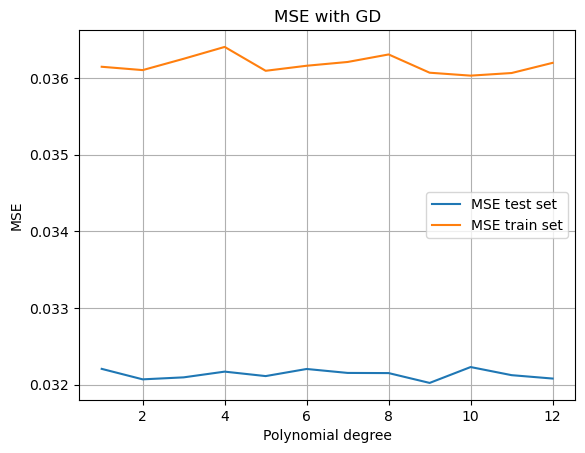

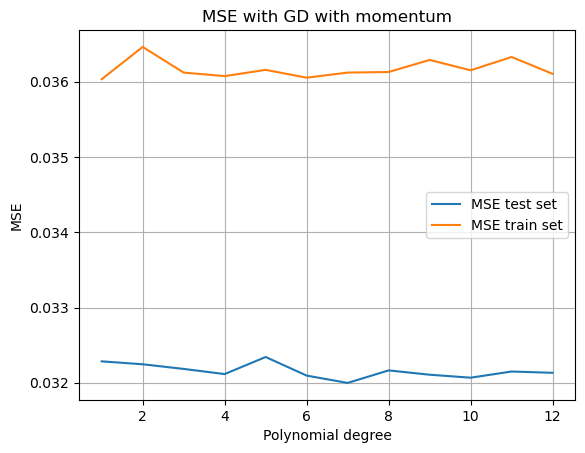

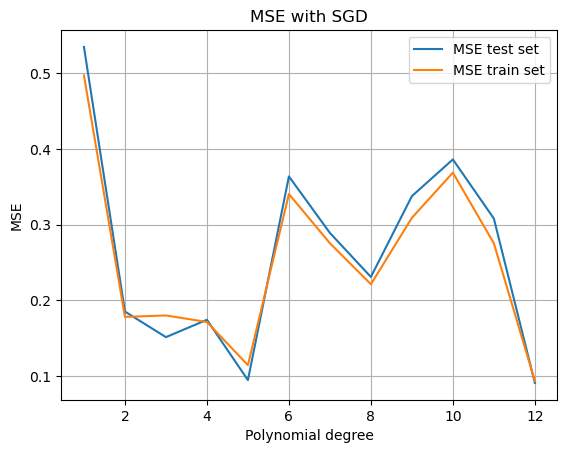

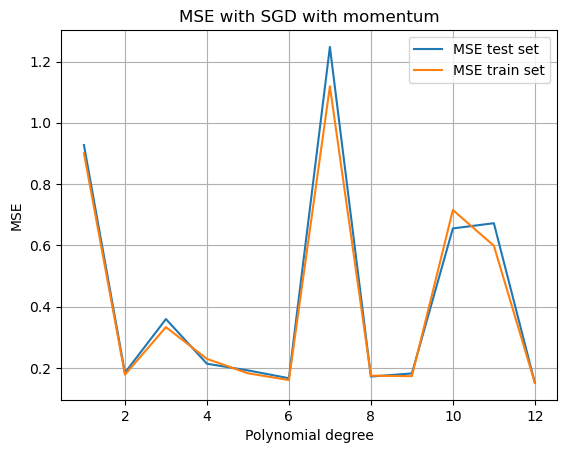

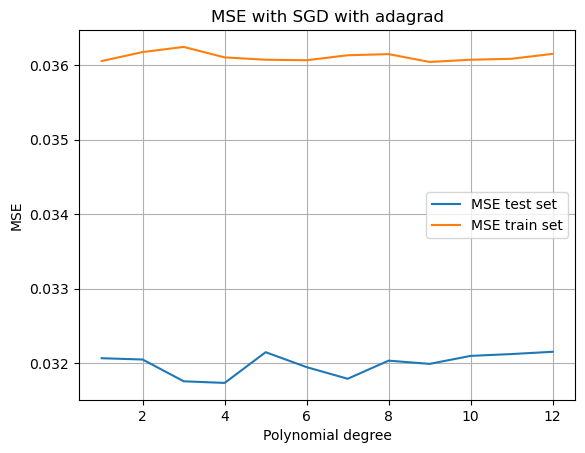

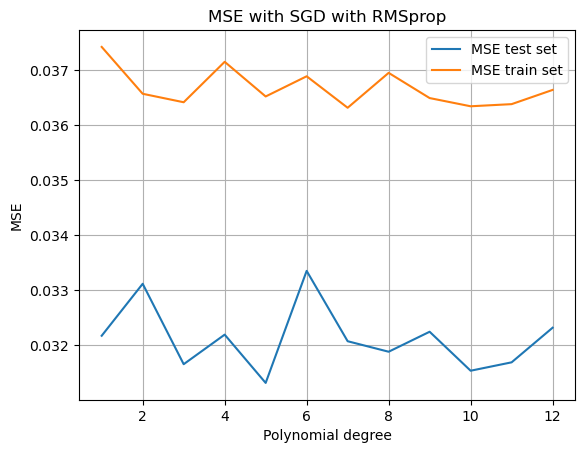

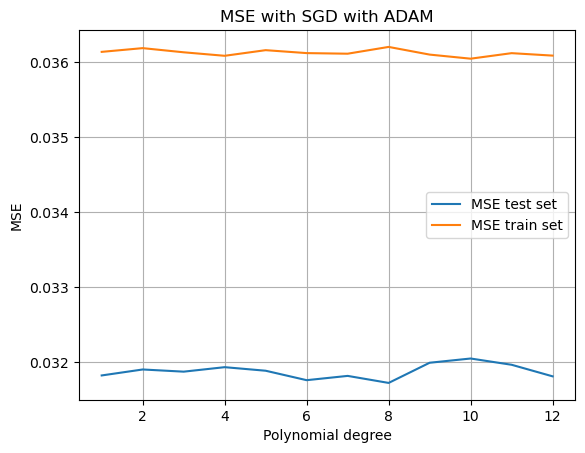

In [14]:
MaxPolynomial = 12

x, y, z = generate_data(FrankesFunction = True)

x_train, x_test, y_train, y_test , z_train, z_test  = train_test_split(x, y, z, test_size=0.2 ,random_state=42)

z_train = z_train.reshape(-1,1)
z_test = z_test.reshape(-1,1)
X_train = create_X(x_train, y_train, MaxPolynomial)
X_test = create_X(x_test, y_test, MaxPolynomial)

mse_test  = np.zeros((MaxPolynomial, 10))
mse_train = np.zeros((MaxPolynomial, 10))
polynomials = np.zeros(MaxPolynomial)
N = 100

for i in range(MaxPolynomial):
    degree = i+1

    c = int((degree+2)*(degree+1)/2)
    X_train = X_train[:,0:c]
    X_test = X_test[:,0:c]

    #Fitting the model and predicting
    z_tilde, z_pred, beta = GradientDescent(X_train, X_test, z_train, len(z_train), N, lmb = 0.001, momentum = False, Ridge =True)
    z_tilde_mom, z_pred_mom, beta_mom = GradientDescent(X_train, X_test, z_train, len(z_train), N, lmb = 0.001, momentum = True, Ridge =True)
    z_tilde_sto, z_pred_sto, beta_sto = StochasticGD(X_train, X_test, z_train, len(z_train), n_epochs=100, size_batch=5, Niterations=1000, delta_momentum=0.3, lmb= 0.001, learningschedule = True, Ridge =True)
    z_tilde_sto_mom, z_pred_sto_mom, beta_sto_mom = StochasticGD(X_train, X_test, z_train, len(z_train), n_epochs=100, size_batch=5, Niterations=1000, delta_momentum=0.3, lmb=0.001, momentum = True, Ridge=True)
    z_tilde_ada, z_pred_ada, beta_ada = AdaGradGD(X_train, X_test, z_train, len(z_train), n_epochs=100, size_batch=5, Niterations=1000, delta_momentum=0.3, delta = 1e-8, lmb=0.001, learningschedule = True, momentum = True, stochastic= True, Ridge=True)
    z_tilde_rms, z_pred_rms, beta_rms = RMSpropGD(X_train, X_test, z_train, len(z_train), n_epochs=100, size_batch= 5, Niterations=1000, delta_momentum=0.3, delta  = 1e-8, rho = 0.99, lmb = 0.001, learningschedule = True, momentum = True, stochastic= True, Ridge = True)
    z_tilde_adam, z_pred_adam, beta_adam = ADAM(X_train, X_test, z_train, len(z_train), n_epochs=100, size_batch= 5, Niterations=1000, delta_momentum=0.3, delta = 1e-8, rho=0.99, beta1 = 0.9, beta2 = 0.999, lmb = 0.001, learningschedule = True, momentum = True, stochastic= True, Ridge = True)
 
    # Calculating the mean squared error
    mse_test[i, 0]  = np.mean(np.mean((z_test - z_pred)**2, axis=1, keepdims=True)) #GD without momentum, test
    mse_train[i, 0]  = np.mean(np.mean((z_train - z_tilde)**2, axis=1, keepdims=True)) #GD without momentum, train
    mse_test[i, 1]  = np.mean(np.mean((z_test - z_pred_mom)**2, axis=1, keepdims=True)) #GD with momentum, test
    mse_train[i, 1]  = np.mean(np.mean((z_train - z_tilde_mom)**2, axis=1, keepdims=True)) #GD with momentum, train
    mse_test[i, 2]  = np.mean(np.mean((z_test - z_pred_sto)**2, axis=1, keepdims=True)) #SGD without momentum, test
    mse_train[i, 2]  = np.mean(np.mean((z_train - z_tilde_sto)**2, axis=1, keepdims=True)) #SGD without momentum, train
    mse_test[i, 3]  = np.mean(np.mean((z_test - z_pred_sto_mom)**2, axis=1, keepdims=True)) #SGD with momentum, test
    mse_train[i, 3]  = np.mean(np.mean((z_train - z_tilde_sto_mom)**2, axis=1, keepdims=True)) #SGD with momentum, train
    mse_test[i, 4]  = np.mean(np.mean((z_test - z_pred_ada)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with Adagrad, test
    mse_train[i, 4]  = np.mean(np.mean((z_train - z_tilde_ada)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with Adagrad, train
    mse_test[i, 5]  = np.mean(np.mean((z_test - z_pred_rms)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with RMSprop, test
    mse_train[i, 5]  = np.mean(np.mean((z_train - z_tilde_rms)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with RMSprop, train
    mse_test[i, 6]  = np.mean(np.mean((z_test - z_pred_adam)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with Adam, test
    mse_train[i, 6]  = np.mean(np.mean((z_train - z_tilde_adam)**2, axis=1, keepdims=True)) #GD or SGD with/without momentum with Adam, train
    #if want to change GD/SGD, with/without momentum etc. you have to change above in the fitting of the model/prediction
    
    polynomials[i] = degree

#Plotting the MSE and R2 scores
plt.title("MSE with GD")
plt.plot(polynomials, mse_test[:,0], label="MSE test set")
plt.plot(polynomials, mse_train[:,0], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with GD with momentum")
plt.plot(polynomials, mse_test[:,1], label="MSE test set")
plt.plot(polynomials, mse_train[:,1], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with SGD")
plt.plot(polynomials, mse_test[:,2], label="MSE test set")
plt.plot(polynomials, mse_train[:,2], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with SGD with momentum")
plt.plot(polynomials, mse_test[:,3], label="MSE test set")
plt.plot(polynomials, mse_train[:,3], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with SGD with adagrad")
plt.plot(polynomials, mse_test[:,4], label="MSE test set")
plt.plot(polynomials, mse_train[:,4], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with SGD with RMSprop")
plt.plot(polynomials, mse_test[:,5], label="MSE test set")
plt.plot(polynomials, mse_train[:,5], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

plt.title("MSE with SGD with ADAM")
plt.plot(polynomials, mse_test[:,6], label="MSE test set")
plt.plot(polynomials, mse_train[:,6], label="MSE train set")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.show()

I'm not sure if the plots are right.. There is such a difference between SGD and GD.\
The plots are for Ridge. If you want to see for OLS, just change Ridge = True into False. Same with the momentum, just change from False to True if you want to see with etc. It just takes so long to get the plots, so I only plotted for some.